Notebook para demostrar la interpolación con Unet y sus resultados sobre una escena de prueba del dataset de KITTI

In [1]:
import sys
import os
import tensorflow as tf
from tensorflow import keras
from unet_model_paper import *
from pointcloud_utils_functions_v2 import *

1/1 [==============================] - 1s 669ms/step


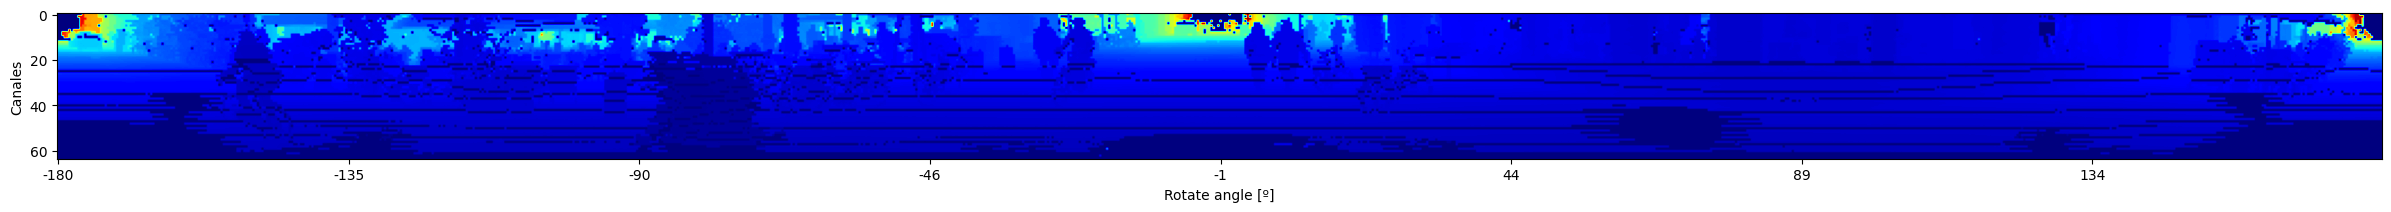

Size: (64, 1024)


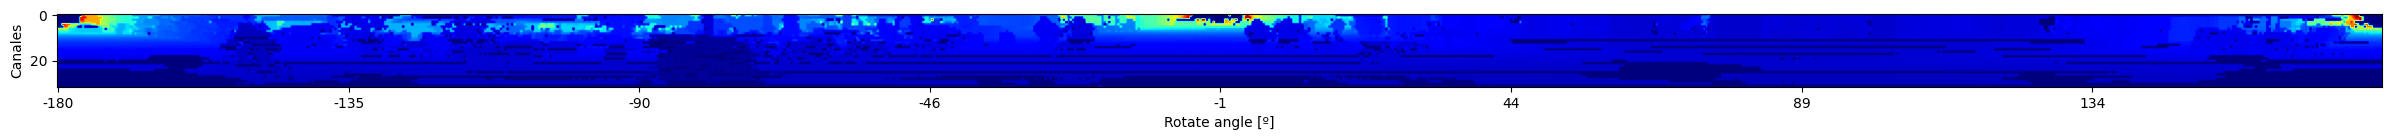

Size: (32, 1024)


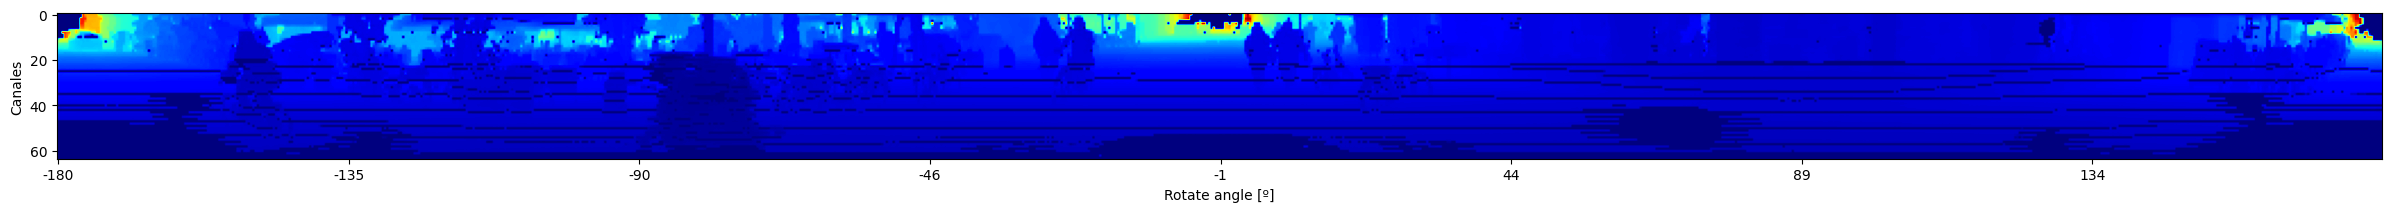

Size: (64, 1024, 1)


In [2]:
dataset_path = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\kitti_3d_object\training'
model_path = r'.\model_results\best_176_0.0053.h5'
pointcloud_fullpath = dataset_path + r'\velodyne\001068.bin'

pointcloud = read_bin(pointcloud_fullpath)
range_image = pointcloud_to_range_image(pointcloud, filter_ego_compensed=False, size=(64, 1024)) / kitti_max_distance

indexes = range(0, 64, 2)
range_image_32 = range_image[indexes]
input_model = np.expand_dims(range_image_32, axis=0)
input_model = np.expand_dims(input_model, axis=-1)


model = keras.models.load_model(model_path)
range_image_gen = model.predict(input_model)

def display_image(img, h_res=0.35, v_fov=(-24.9, 2.0), h_fov=(-180, 180), cmap='jet'):
    def scale_xaxis(axis_value, *args):
        if h_fov[0] > 0:
            return int(np.round((axis_value * h_res + h_fov[0])))
        else:
            return int(np.round((axis_value * h_res - abs(h_fov[0]))))

    plt.subplots(1,1, figsize = (30,20))
    #plt.title(f"Range Image - Vertical FOV ({v_fov[0]}º, {v_fov[1]}º) & Horizontal FOV ({h_fov[0]}º , {h_fov[1]}º) - 0º means the front of the car")
    plt.imshow(img, cmap=cmap)
    plt.xticks(np.arange(0,len(img[1]),len(img[1])/8))
    formatter = FuncFormatter(scale_xaxis)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xlabel("Rotate angle [º]")
    plt.ylabel("Canales")
    plt.show()

    print(f"Size: {img.shape}")

display_image(range_image)
display_image(range_image_32)
display_image(range_image_gen[0])

In [3]:
def MC_drop(input_model, hr_image, iterate_count=50):
    hr_image = np.expand_dims(hr_image, axis=0)
    hr_image = np.expand_dims(hr_image, axis=-1) #[1, 64, 1024, 1]
    test_data_input = input_model
    this_test = np.empty([iterate_count, low_res, image_columns, channel_num], dtype=np.float32)
    test_data_prediction = np.empty([test_data_input.shape[0], high_res, image_columns, 2], dtype=np.float32)

    for i in range(test_data_prediction.shape[0]):

        print('Processing {} th of {} images ... '.format(i, test_data_prediction.shape[0]))
        
        for j in range(iterate_count):
            this_test[j] = test_data_input[i]

        this_prediction = model.predict(this_test, verbose=1)

        this_prediction_mean = np.mean(this_prediction, axis=0)
        this_prediction_var = np.std(this_prediction, axis=0)
        test_data_prediction[i,:,:,0:1] = this_prediction_mean
        test_data_prediction[i,:,:,1:2] = this_prediction_var

    low_res_index = range(0, high_res, upscaling_factor)
    test_data_prediction[:,low_res_index,:,0:1] = hr_image[:,low_res_index,:,0:1]
    test_data_prediction_reduced = np.copy(test_data_prediction[:,:,:,0:1])
    
    # remove noise
    if len(test_data_prediction.shape) == 4 and test_data_prediction.shape[-1] == 2:
        noiseLabels = test_data_prediction[:,:,:,1:2]
        test_data_prediction_reduced[noiseLabels > test_data_prediction_reduced * 0.03] = 0 # after noise removal
        test_data_prediction_reduced[:,low_res_index] = hr_image[:,low_res_index]

    test_data_prediction[:,:,:,1:2] = None
    return test_data_prediction, test_data_prediction_reduced

test_data_prediction, test_data_prediction_reduced = MC_drop(input_model, range_image)

Processing 0 th of 1 images ... 
2/2 [==============================] - 13s 5s/step


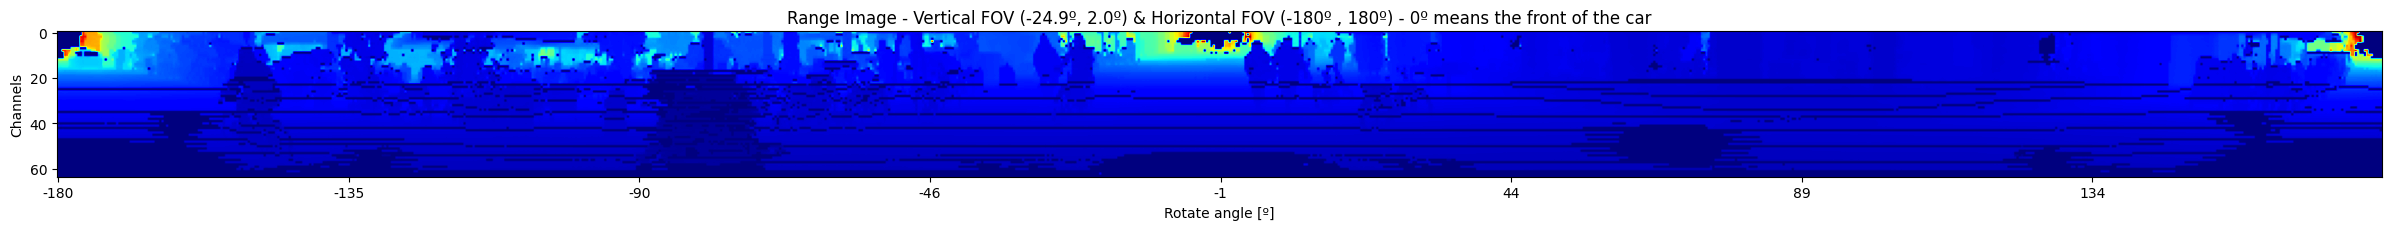

Size: (64, 1024, 1)


In [4]:
display_range_image(test_data_prediction_reduced[0])

In [8]:
np.save(r'.\range_images\original.npy', range_image * kitti_max_distance)
np.save(r'.\range_images\original_32.npy', range_image_32 * kitti_max_distance)
np.save(r'.\range_images\unet_MC.npy', test_data_prediction_reduced[0] * kitti_max_distance)

In [27]:
pointcloud = range_image_to_pointcloud(test_data_prediction_reduced[0] * kitti_max_distance)
save_ply(pointcloud, r'.\pointcloud_interpolated_MC.ply')